In [1]:
%matplotlib inline

REPO_ROOT = "/usr/src/app"

import collections
import json
import math
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import theano
import theano.tensor as T
import lasagne

import util
reload(util)

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN not available)


<module 'util' from 'util.pyc'>

In [2]:
with open("%s/model-data/metadata.pickle" % (REPO_ROOT,), "r") as f:
    size_data = pickle.load(f)
    
TRAIN_SIZES = size_data["train_sizes"]
TEST_SIZE = size_data["test_size"]

BATCH_SIZE = 100
VOCAB_SIZE = 10000
WORD_EMBEDDING_SIZE = 1600

In [3]:
with open("%s/scripts/table_balanced.json" % REPO_ROOT) as f:
    data_table = json.load(f)

In [4]:
class Vocabulary(object):
    def __init__(self, data_table, tokenizer, parser, vocab_size):
        self.vocab_size = vocab_size
        
        counts = collections.Counter()
        
        for idx, script in enumerate(parser(data_table)):
            if idx % 1000 == 0:
                print "%d done." % idx
                
            tokens = tokenizer(script)
            counts.update(tokens)

        self.word_table = {
            entry[0]: idx
            for idx, entry in enumerate(counts.most_common(self.vocab_size - 1))
        }

        print "Done"
        
    def numerize(self, word):
        return self.word_table.get(word, self.vocab_size-1)
    
    def size(self):
        return self.vocab_size
    
    def save(self, name):
        with open("%s/model-data/vocab_%s.pickle" % (REPO_ROOT, name), "w") as f:
            pickle.dump(self.word_table, f)

In [5]:
class Word2Vec(object):
    def __init__(self, vocab, data_table, tokenizer, parser,
                 batch_size, embedding_size, train_size, test_size):
        self.vocab = vocab
        self.data_table = data_table
        self.tokenizer = tokenizer
        self.parser = parser
        self.batch_size = batch_size
        self.vocab_size = vocab.size()
        self.embedding_size = embedding_size
        self.train_size = train_size
        self.test_size = test_size
        
        self.input_var = T.lvector('inputs')
        self.target_var = T.lvector('targets')
    
        l_context = lasagne.layers.InputLayer(shape=(batch_size,), input_var=self.input_var)

        l_embedding = lasagne.layers.EmbeddingLayer(l_context, input_size=self.vocab_size, output_size=embedding_size)

        l_in_drop = lasagne.layers.DropoutLayer(l_embedding, p=0.2)

        l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=40,
            nonlinearity=lasagne.nonlinearities.tanh,
            W=lasagne.init.GlorotUniform())

        l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

        output = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=self.vocab_size,
            nonlinearity=lasagne.nonlinearities.softmax)

        prediction = lasagne.layers.get_output(output)
        loss = lasagne.objectives.categorical_crossentropy(prediction, self.target_var)
        loss = loss.mean()

        params = lasagne.layers.get_all_params(output, trainable=True)
        updates = lasagne.updates.adam(loss, params)

        test_prediction = lasagne.layers.get_output(output, deterministic=True)
        test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, self.target_var)
        test_loss = test_loss.mean()

        test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), self.target_var),
                      dtype=theano.config.floatX)

        self.train_fn = theano.function([self.input_var, self.target_var], loss, updates=updates)
        self.val_fn = theano.function([self.input_var, self.target_var], [test_loss, test_acc])
        
        input_tokens = T.ivector('token')
        l_in = lasagne.layers.InputLayer(
            shape=(None,), input_var=input_tokens)
        l_emb = lasagne.layers.EmbeddingLayer(
            incoming=l_in,
            input_size=self.vocab_size,
            output_size=embedding_size,
            W=l_embedding.W)
        embedding = lasagne.layers.get_output(l_emb)
        self.embed = theano.function([input_tokens], embedding)

    def generate_batch(self, table, sample_ratio):
        x = np.ndarray(shape=(self.batch_size,), dtype=np.int32)
        y = np.ndarray(shape=(self.batch_size,), dtype=np.int32)
        batch_idx = 0
        for script in self.parser(table):
            tokens = [self.vocab.numerize(token) for token in self.tokenizer(script)]
            if len(tokens) < 2:
                continue

            sample_size = len(tokens) - 2
            num_to_sample = max(1, int(math.floor(sample_size * sample_ratio)))
            for pos in random.sample(range(0, sample_size + 1), num_to_sample):
                x[batch_idx] = tokens[pos]
                y[batch_idx] = tokens[pos+1]
                batch_idx += 1
                if batch_idx == self.batch_size:
                    yield x, y
                    batch_idx = 0
    
    def train(self):
        best_accuracy = 0
        bad_count = 0
        for epoch in xrange(999):
            # In each epoch, we do a full pass over the training data:
            train_err = 0
            train_batches = 0

            for inputs, targets in self.generate_batch(self.data_table[:self.train_size], 1.0):
                train_err += self.train_fn(inputs, targets)
                train_batches += 1
                if train_batches % 1000 == 0:
                    # And a pass over the validation data:
                    val_err = 0
                    val_acc = 0
                    val_batches = 0
                    for inputs, targets in self.generate_batch(self.data_table[-self.test_size:], 0.005):
                        err, acc = self.val_fn(inputs, targets)
                        val_err += err
                        val_acc += acc
                        val_batches += 1

                    current_accuracy = val_acc / val_batches

                    # Then we print the results for this epoch:
                    print("Epoch {} Batch {} - loss {:.2f}, accuracy {:.2f} %".format(
                        epoch + 1, train_batches, train_err / train_batches, current_accuracy * 100))

                    if current_accuracy > best_accuracy:
                        best_accuracy = current_accuracy
                        bad_count = 0
                    else:
                        bad_count += 1
                        if bad_count > 4:
                            break
                            
            if bad_count > 4:
                break
                
        self.embeddings = self.embed(range(self.vocab_size))
    
    def plot(self):
        model = TSNE(n_components=2, random_state=0)
        points = model.fit_transform(self.embeddings)

        idx_dict = {v: k for k, v in self.vocab.word_table.iteritems()}
        words = [idx_dict[idx] for idx in xrange(100)]

        fig, ax = plt.subplots(figsize=(12, 12))
        ax.plot(points[:100,0], points[:100,1], 'bo', markersize=0)

        for i, txt in enumerate(words[:100]):
            ax.annotate(txt, (points[i][0],points[i][1]))
            
    def embedding_lookup(self, table_rows):
        vocab_size, embed_size = np.shape(self.embeddings)
        embeddings_trans = np.transpose(self.embeddings)

        ret = np.zeros([len(table_rows), embed_size])
        for script_idx, script in enumerate(self.parser(table_rows)):
            token_ids = [
                self.vocab.numerize(token)
                for token in self.tokenizer(script)
            ]
            word_vec = np.zeros(vocab_size)
            for token_id in token_ids:
                word_vec[token_id] += 1

            ret[script_idx] = np.matmul(embeddings_trans, word_vec)

        return ret

    def save_training_set(self, model_name):
        data = {
            "X_train": self.embedding_lookup(self.data_table[:self.train_size]),
            "Y_train": np.array([item["flag-any"] for item in self.data_table[:self.train_size]]),
            "X_test": self.embedding_lookup(self.data_table[-self.test_size:]),
            "Y_test": np.array([item["flag-any"] for item in self.data_table[-self.test_size:]]),
            "shas_test": [item["sha"] for item in self.data_table[-self.test_size:]],
        }

        with open("%s/model-data/dataset_%s_%d.pickle" % (REPO_ROOT, model_name, self.train_size), "w") as f:
            pickle.dump(data, f)
            
    def save_embeddings(self, model_name):
        with open("%s/model-data/embeddings_%s_%d.pickle" % (REPO_ROOT, model_name, self.train_size), "w") as f:
            pickle.dump(self.embeddings, f)

In [8]:
print "Word2Vec vocabulary..."
vocab_js = Vocabulary(data_table, util.tokenize_js, util.parse_js, VOCAB_SIZE)
vocab_js.save("js")

Word2Vec vocabulary...
0 done.
1000 done.
2000 done.
3000 done.
4000 done.
5000 done.
6000 done.
7000 done.
8000 done.
9000 done.
10000 done.
11000 done.
12000 done.
13000 done.
14000 done.
15000 done.
16000 done.
17000 done.
18000 done.
19000 done.
20000 done.
21000 done.
22000 done.
Done


In [9]:
for train_size in TRAIN_SIZES:
    print "Random2Vec Training size %d" % train_size

    g = Word2Vec(vocab_js, data_table, util.tokenize_js, util.parse_js,
                 BATCH_SIZE, WORD_EMBEDDING_SIZE, train_size, TEST_SIZE)
    g.embeddings = np.random.rand(VOCAB_SIZE, WORD_EMBEDDING_SIZE)
    g.save_training_set("Random2Vec")
    
print "Done training."

Random2Vec Training size 300
Random2Vec Training size 600
Random2Vec Training size 1200
Random2Vec Training size 2400
Random2Vec Training size 4800
Random2Vec Training size 9600
Random2Vec Training size 19200
Done training.


Word2Vec Training size 19200
Epoch 1 Batch 1000 - loss 4.09, accuracy 20.41 %
Epoch 1 Batch 2000 - loss 4.15, accuracy 22.82 %
Epoch 1 Batch 3000 - loss 4.10, accuracy 26.34 %
Epoch 1 Batch 4000 - loss 3.89, accuracy 18.03 %
Epoch 1 Batch 5000 - loss 3.68, accuracy 16.23 %
Epoch 1 Batch 6000 - loss 3.52, accuracy 18.96 %
Epoch 1 Batch 7000 - loss 3.39, accuracy 20.06 %
Epoch 1 Batch 8000 - loss 3.29, accuracy 18.99 %
Saving embeddings...
Done training.


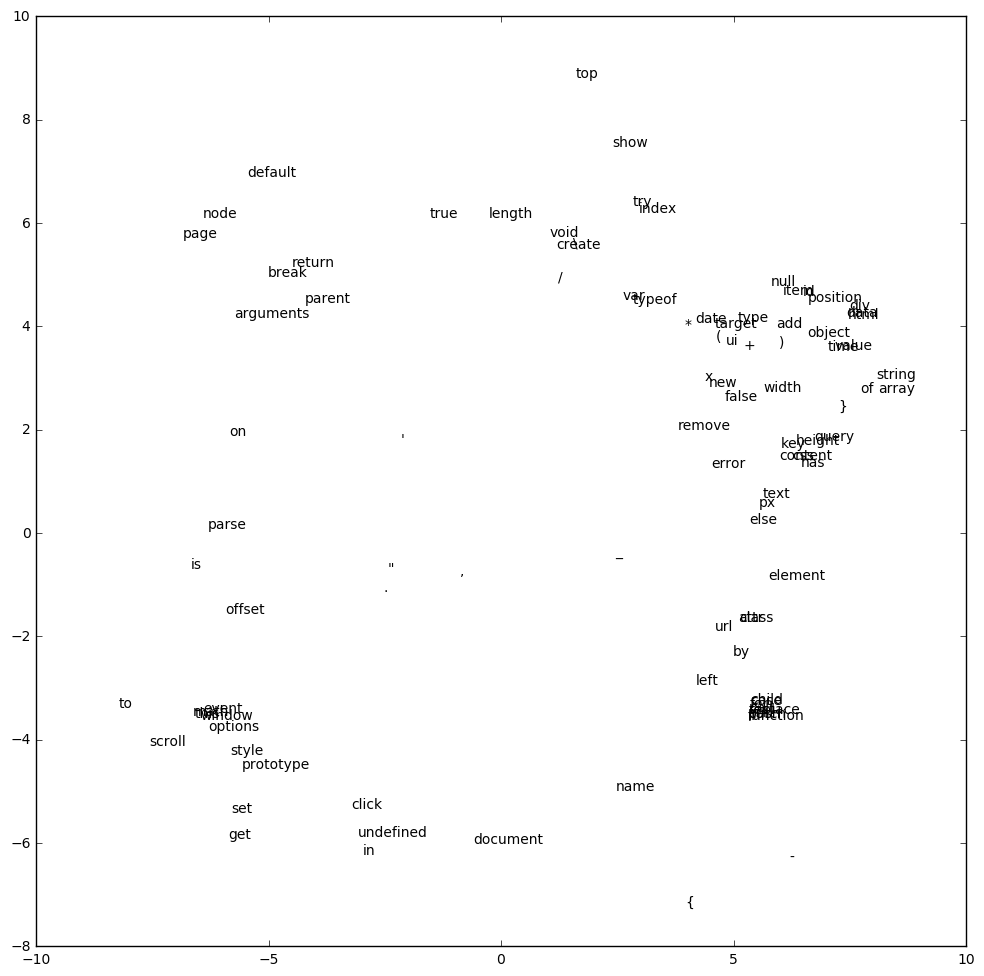

In [13]:
for train_size in [19200]: # TRAIN_SIZES:
    print "Word2Vec Training size %d" % train_size
    
    g = Word2Vec(vocab_js, data_table, util.tokenize_js, util.parse_js,
                 BATCH_SIZE, WORD_EMBEDDING_SIZE, train_size, TEST_SIZE)
    g.train()
    print "Saving embeddings..."
    g.save_training_set("Word2Vec")
    g.save_embeddings("Word2Vec")
    
    if train_size == TRAIN_SIZES[-1]:
        g.plot()
    
print "Done training."

In [14]:
print "AST2Vec vocabulary..."
vocab_ast = Vocabulary(data_table, util.tokenize_ast, util.parse_ast, VOCAB_SIZE)
vocab_ast.save("ast")

AST2Vec vocabulary...
0 done.
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
1000 done.
2000 done.
3000 done.
4000 done.
5000 done.
6000 done.
7000 done.
8000 done.
9000 done.
10000 done.
11000 done.
12000 done.
13000 done.
14000 done.
15000 done.
16000 done.
17000 done.
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
18000 done.
19000 done.
20000 done.
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
21000 done.
22000 done.
Done


AST2Vec Training size 19200
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
Epoch 1 Batch 1000 - loss 4.91, accuracy 14.51 %
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
Epoch 1 Batch 2000 - loss 4.62, accuracy 20.02 %
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
Epoch 1 Batch 3000 - loss 4.23, accuracy 20.43 %
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
Epoch 1 Batch 4000 - loss 3.71, accuracy 19.31 %
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
Epoch 1 Batch 5000 - loss 3.36, accuracy 19.90 %
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
Epoch 1 Batch 6000 - loss 3.12, accuracy 19.84 %
Failed to parse JSON! maximum recursion depth exceeded while calling a Python object
Epoch 1 Batch 7000 - loss 3.13, accuracy 18.29 %
Failed to parse JSON! maximum recu

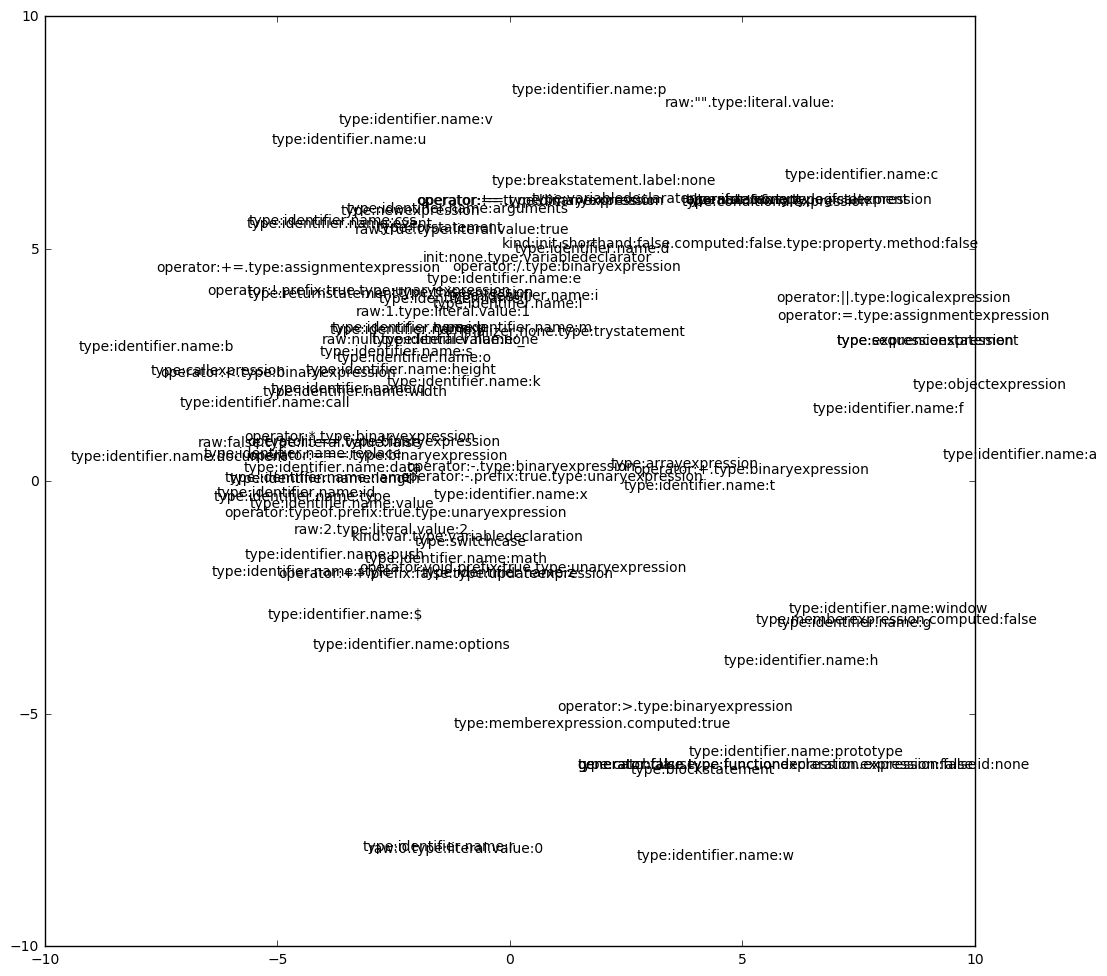

In [15]:
for train_size in [19200]: # TRAIN_SIZES:
    print "AST2Vec Training size %d" % train_size
    
    g = Word2Vec(vocab_ast, data_table, util.tokenize_ast, util.parse_ast,
                 BATCH_SIZE, WORD_EMBEDDING_SIZE, train_size, TEST_SIZE)
    g.train()
    print "Saving embeddings..."
    g.save_training_set("AST2Vec")
    g.save_embeddings("AST2Vec")
    
    if train_size == TRAIN_SIZES[-1]:
        g.plot()
      
print "Done training."